In [1]:
# check if config exists
try:
    config
except NameError:
    config_exists = False
else:
    config_exists = True

# make config if it does not exist already (e.g. passed in by papermill)
if not(config_exists):
    # set up some config for the experiment run
    config = {
        "data_path" : "C:/Users/nico_/Desktop/ITBA/TFI/github/df_procesado/trollers_fe.csv",
    }
print(config)

{'data_path': 'C:/Users/nico_/Desktop/ITBA/TFI/github/df_procesado/trollers_fe.csv'}


In [2]:
# Importing core libraries
#https://www.kaggle.com/code/lucamassaron/tutorial-bayesian-optimization-with-lightgbm/notebook
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifiers
import lightgbm as lgb

# Model selection
from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Cargamos el dataset.

In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

df = pd.read_csv(config['data_path'], header="infer", sep=",",error_bad_lines=False, engine ='python')

In [4]:
df = df.drop(['mmsi', 'source','timestamp','source','datetime','distance_from_shore','distance_from_port'], axis = 1)
lagged_columns = ['A0', 'J0', 'C0','speed_lag_1', 'speed_lag_2',
       'speed_lag_3', 'speed_lag_4', 'speed_lag_5', 'speed_lag_6',
       'course_lag_1', 'course_lag_2', 'course_lag_3', 'course_lag_4',
       'course_lag_5', 'course_lag_6', 'S0_lag_1', 'S0_lag_2', 'S0_lag_3',
       'S0_lag_4', 'S0_lag_5', 'S0_lag_6', 'A0_lag_1', 'A0_lag_2', 'A0_lag_3',
       'A0_lag_4', 'A0_lag_5', 'A0_lag_6', 'J0_lag_1', 'J0_lag_2', 'J0_lag_3',
       'J0_lag_4', 'J0_lag_5', 'J0_lag_6', 'C0_lag_1', 'C0_lag_2', 'C0_lag_3',
       'C0_lag_4', 'C0_lag_5', 'C0_lag_6']
for column in lagged_columns:
    df[column]=df[column].abs()

print(df)


       speed    course       lat       lon is_fishing  sun_state   distance  \
0        6.3  0.830278  0.967198  0.251943         NO          1  12.460250   
1        6.4  0.855000  0.967377  0.251483         NO          1   3.130300   
2        8.4  0.350833  0.967056  0.251651         NO          1   2.251642   
3        8.3  0.372778  0.966446  0.252871         NO          1   8.629961   
4        7.7  0.268889  0.966132  0.253582         NO          1   4.921015   
...      ...       ...       ...       ...        ...        ...        ...   
13991    2.0  0.246667  0.996371  0.212425         NO          1   0.184542   
13992    2.7  0.116667  0.996361  0.212444         NO          1   0.134451   
13993    0.3  0.719722  0.996352  0.212436         NO          1   0.076645   
13994    4.4  0.808056  0.996348  0.212445         NO          1   0.063297   
13995    0.3  0.353889  0.996313  0.212339         NO          1   0.712027   

       timediff        S0            A0  ...      J

Generamos los vectores de train y test.

In [5]:
#Generamos train y test.

#Si la longitud del dataset es mayor a 10000, partiremos agrupado por "is_fishing" ya que nos puede tocar un conjunto con is_fishing='SI' vacio.
#if len(dataset)>10000:
    #df = df.sample(n=10000, random_state=1)
#    df = df.groupby("is_fishing").sample(n=7500, random_state=1,replace=True)
#    df = df.drop_duplicates()

X = df.drop('is_fishing',axis=1)
y = df['is_fishing']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=50)
print(len(df[df['is_fishing']=='SI']))
print(len(df[df['is_fishing']=='NO']))



1286
12710


Funcion para evaluar los modelos.

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import tabulate
from sklearn.metrics import confusion_matrix, accuracy_score


def evaluate_model(title,y_test, y_pred):

    cm = confusion_matrix(y_test, y_pred)
    display(Markdown(title))
    cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['NO', 'SI'])
    cmd_obj.plot()
    cmd_obj.ax_.set(
                    title='Matriz de confusión.', 
                    xlabel='Predict Values', 
                    ylabel='Actual Values')
    plt.show()
    _precision_score = precision_score(y_test, y_pred,pos_label='SI')
    _recall_score = recall_score(y_test, y_pred, pos_label='SI')
    _accuracy_score = accuracy_score(y_test, y_pred)
    _f1_score = f1_score(y_test, y_pred, pos_label='SI')

    data = [["Precision","Recall","Accuracy","F1"],
            ["%.2f" % _precision_score, "%.2f" % _recall_score, "%.2f" % _accuracy_score, "%.2f" % _f1_score ]]
    table = tabulate.tabulate(data, tablefmt='html')
    display(table)
    return _precision_score, _recall_score, _accuracy_score, _f1_score


In [7]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params


In [8]:
# Setting the scoring function
scoring = make_scorer(partial(mean_squared_error, squared=False), 
                      greater_is_better=False)


In [9]:

search_spaces = {
    'reg_sqrt': Categorical([True, False]),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(1, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
   }

In [10]:
reg = lgb.LGBMRegressor(boosting_type='gbdt',
                        # Probar con dart, asi en el ejemplo ... 
                        objective='binary',
                        metric='rmse',
                        n_jobs=1, 
                        verbose=-1,
                        random_state=0)

In [11]:
# Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces,                      
                    scoring=scoring,                           
                    n_iter=60,                                        # max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

In [13]:
# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 60 * 7) # We impose a time limit (6 hours)

best_params = report_perf(opt, X, y,'LightGBM_regression')


ValueError: Series.dtypes must be int, float or bool

lgbm grid search

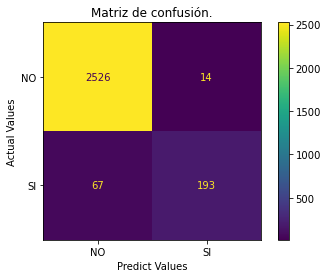

Precision,Recall,Accuracy,F1
0.93,0.74,0.97,0.83


In [27]:

'''
opt_parameters = gs.best_params_
#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

y_pred = clf_final.predict(X_test)
lgbm_precision_score_auc, lgbm_recall_score_auc, lgbm_accuracy_score_auc, lgbm_f1_score_auc = evaluate_model('lgbm grid search', y_test, y_pred)
'''


In [ ]:
print('Plotting feature importances...')
ax = lgb.plot_importance(clf_final, max_num_features=20,importance_type ='gain',figsize=(20, 10) )
plt.figure(figsize=(100, 10))
plt.show()

Arboles de decision optimizado

In [28]:
from IPython.display import Markdown as md
md(f'''| Algorithm     | Precision     | Recall        | Accuracy      | F1            |
| ------------- | ------------- | ------------- | ------------- | ------------- |
|Random Forest       |{rf_precision_score:.3f} |	{rf_recall_score:.3f}|	{rf_accuracy_score:.3f}|	{rf_f1_score:.3f}|
| LightGBM      |{lgbm_precision_score_auc:.3f}|	{lgbm_recall_score_auc:.3f}|	{lgbm_accuracy_score_auc:.3f}|	{lgbm_f1_score_auc:.3f}|
'''
       )


| Algorithm     | Precision     | Recall        | Accuracy      | F1            |
| ------------- | ------------- | ------------- | ------------- | ------------- |
| LightGBM_auc      |0.932|	0.742|	0.971|	0.827|
